In [2]:
!pip install nltk
!pip install beautifulsoup4
!pip install lxml

In [49]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import torch
from collections import Counter

import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print('=3')

=3


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data = pd.read_csv(os.getenv("HOME")+"/work/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data = data[['Text', 'Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
65582,"If you didn't like the taste of cashews, you p...",Spicy Flavor Almost Totally Hides the Taste of...
12283,I found Dogswell products 7 years ago when my ...,LOVE LOVE LOVE Dogswell products!
36842,I bought these organic chocolate covered Brazi...,Not all nuts are fresh...
19705,My son loves this food. He is 16 months now a...,My son loves this
53746,French Market is a bold delicious coffee and ...,Great coffee!
91155,Purchased this item from Ace Photo Digital; it...,K-cup holder--ace photo digital
29108,We have used Colavita olive oil now for many y...,The Only Olive Oil We Buy
97600,I haven't really had much luck with any lavend...,Does not taste like natural lavender
1975,I ordered this for a friend at South Carolina ...,Totally delicious and delightful!
10419,Normally I buy the Fruztio Freeze Dried Aprico...,yuck!


In [7]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [8]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [9]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [10]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


In [11]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [12]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [14]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [15]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

for sentence in data['Text']:
    clean_text.append(preprocess_sentence(sentence))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [17]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_summary = []

for sentence in data['Summary']:
    clean_summary.append(preprocess_sentence(sentence, remove_stopwords=False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

/tmp/ipykernel_682/2266808870.py:4: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [18]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [19]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [20]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


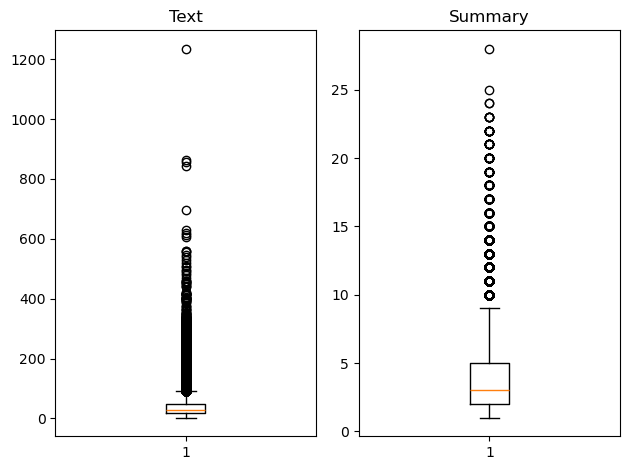

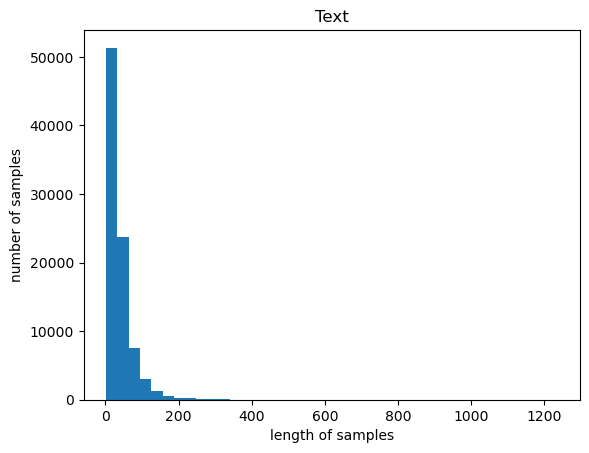

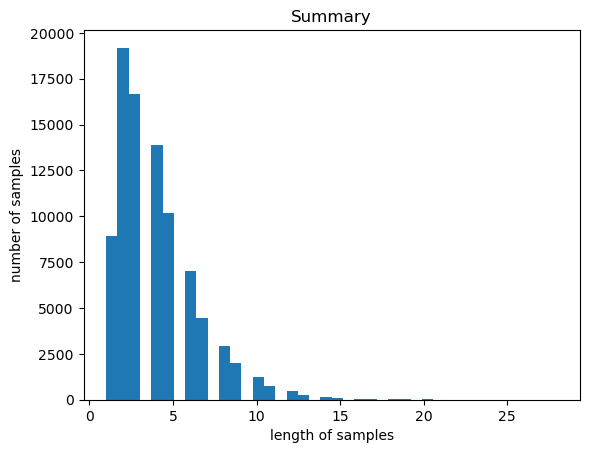

In [22]:
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
text_max_len = 50
summary_max_len = 8
print('=3')

=3


In [24]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [25]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [26]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


In [27]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [28]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [29]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[23644 38814  2985 ... 24896 49841 37155]


In [30]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [31]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [32]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


In [33]:
def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [34]:
threshold = 7

# 전처리된 데이터 사용
text_data = data['Text'].tolist()
summary_data = data['Summary'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 35610
등장 빈도가 6번 이하인 희귀 단어의 수: 26409
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9201
단어 집합에서 희귀 단어의 비율: 74.16175231676495
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.988036889250968


In [35]:
src_vocab_size = 8000

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)
print('=3')

=3


In [36]:
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[142, 6, 475, 7179, 112, 1001, 1152, 5, 555, 415, 157, 696, 218, 1249, 1952, 1194, 122, 148, 1, 733, 1, 1855, 4, 430, 37, 4252, 5, 2317, 153, 842, 11, 26, 3893, 890, 4778, 528], [81, 129, 89, 2318, 127, 20, 571, 97, 24, 655, 4517, 131, 105, 24, 6, 15, 511, 1246, 153, 127, 51, 35, 250, 42, 4, 531, 546, 727, 250, 56, 219, 476, 116, 43, 292, 129, 508, 2318, 127, 83], [181, 615, 308, 4, 5, 89, 7]]
[[3473, 178, 211, 317, 150, 87, 70, 281, 1, 317, 381, 383, 70, 6, 263, 21, 955], [546, 59, 46, 397, 56, 156, 1552, 1056, 283, 103, 414, 149, 86, 90, 874, 10, 2954, 600, 78, 44, 208, 697, 747, 4, 217, 583, 114, 2849, 133, 332, 2831, 106, 5368, 10, 613, 92, 18, 1063, 255, 106, 113, 75, 10, 21, 62, 501], [33, 1467, 4094, 50, 917, 33, 84, 134, 60, 307, 3608, 358, 60, 1818, 376, 57, 328, 13, 307]]


In [37]:
def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)
print('=3')

=3


In [38]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10495
등장 빈도가 5번 이하인 희귀 단어의 수: 8130
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2365
단어 집합에서 희귀 단어의 비율: 77.46545974273464
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.899251449294089


In [39]:
tar_vocab_size = 2000
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 1166, 22], [2, 24], [2, 125, 353], [2, 1519, 52, 10], [2, 1, 76, 26, 346, 99]]
target
decoder  [[1166, 22, 3], [24, 3], [125, 353, 3], [1519, 52, 10, 3], [1, 76, 26, 346, 99, 3]]


In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


In [42]:
# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=summary_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=summary_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=summary_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=summary_max_len)

print('=3')

=3


In [44]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
src_vocab_size = len(src_vocab)  # 단어 집합 크기

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [45]:
# 디코더 설계
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [46]:
# 디코더의 출력층
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.softmax_layer = nn.Linear(hidden_size, vocab_size)  # 출력층 정의

    def forward(self, encoder_input, decoder_input):
        # 인코더 실행
        encoder_output, hidden, cell = self.encoder(encoder_input)

        # 디코더 실행
        decoder_output, _, _ = self.decoder(decoder_input, hidden, cell)

        # 출력층 적용 (Softmax는 Loss 내부에서 적용되므로 생략 가능)
        output = self.softmax_layer(decoder_output)
        return output

# 모델 정의
model = Seq2Seq(encoder, decoder, tar_vocab_size)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(2000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (softmax_layer): Linear(in_features=256, out_features=2000, bias=True)
)


In [48]:
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

# 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)
print(model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(8000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(2000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2000, bias=True)
)


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Hyperparameters
batch_size = 256
epochs = 50
learning_rate = 0.001
patience = 2

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [53]:
train_losses = []
val_losses = []

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

In [54]:
%%time
# 30분 이상 시간이 걸릴 수 있습니다. GPU 환경에서 학습하는 것을 권장합니다.
# 학습 실행
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 4.8052 | Val Loss: 4.5141
Epoch 2/50 | Train Loss: 4.4471 | Val Loss: 4.3150
Epoch 3/50 | Train Loss: 4.1941 | Val Loss: 4.0498
Epoch 4/50 | Train Loss: 3.9751 | Val Loss: 3.9012
Epoch 5/50 | Train Loss: 3.8233 | Val Loss: 3.7891
Epoch 6/50 | Train Loss: 3.6959 | Val Loss: 3.7008
Epoch 7/50 | Train Loss: 3.5781 | Val Loss: 3.6347
Epoch 8/50 | Train Loss: 3.4752 | Val Loss: 3.5822
Epoch 9/50 | Train Loss: 3.3777 | Val Loss: 3.5514
Epoch 10/50 | Train Loss: 3.2858 | Val Loss: 3.5371
Epoch 11/50 | Train Loss: 3.2025 | Val Loss: 3.5344
Epoch 12/50 | Train Loss: 3.1205 | Val Loss: 3.5320
Epoch 13/50 | Train Loss: 3.0381 | Val Loss: 3.5504
Epoch 14/50 | Train Loss: 2.9590 | Val Loss: 3.5657
Early stopping triggered at epoch 14
CPU times: user 2min 48s, sys: 428 ms, total: 2min 49s
Wall time: 2min 49s


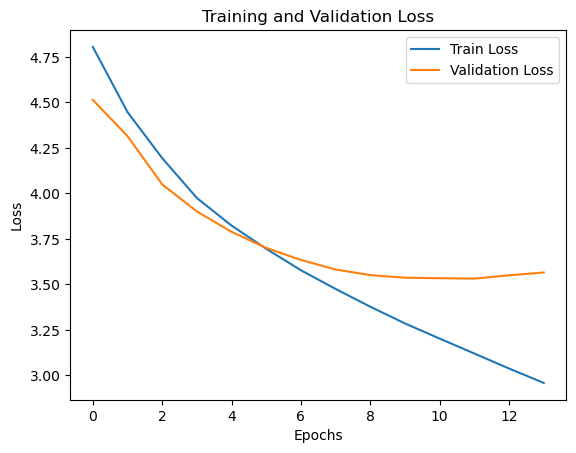

In [55]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [56]:
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder.to(device)

# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)

print('=3')

=3


In [58]:
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)
print('=3')

=3


In [59]:
def decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, summary_max_len, device):
    # 입력을 PyTorch Tensor로 변환
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

    # 인코더 실행하여 초기 상태(hidden, cell) 얻기
    with torch.no_grad():
        e_out, e_h, e_c = encoder(input_seq)

    e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

    # <SOS>에 해당하는 토큰 생성
    target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 실행
        with torch.no_grad():
            output_tokens, h, c = decoder(target_seq, e_h, e_c)

        # 가장 높은 확률을 가진 단어 선택
        sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence
print("=3")

=3


In [60]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

print('=3')

=3


In [61]:
%%time
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 요약 :", decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, summary_max_len, device))
    print("\n")

원문 : diet root beer earned rock solid four stars reason <UNK> star recall authentic root beers youth <UNK> reserve ultimate rating beverage delivers crisp clear creamy <UNK> taste discernible <UNK> try stuff like delivered door cents pop cannot go awfully wrong
실제 요약 : <UNK> good root
예측 요약 :  whole so blend will sugar white tea


원문 : love fact come plastic cup style eco friendly taste one best reordering soon
실제 요약 : great flavor
예측 요약 :  okay poor an olive good likes blend


원문 : hard time finding really good decaf stumbled across company searching tried ago fell love cannot say enough company coffee excellent customer service coffee great keep coming back highly recommend company coffee maple coffee great would recommend trying many flavors found excellent
실제 요약 : love this coffee
예측 요약 :  whole tastegreat cheese like yummy at olive


원문 : great jerkey substitute vegetarian problem stale hard chew fresh absolutely awesome stonewall favorite brand vegetarian jerkey like jerkey hot s

<timed exec>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_682/366614501.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


예측 요약 :  okay poor an sugar yummy had could


원문 : shakes delicious filling times need something hold dinner shakes trick plus help keep liquid intake usually drink half first thing morning another half later day
실제 요약 : excellent source of protein
예측 요약 :  okay poor good pretty olive hot fruit


원문 : like colored water little flavor coffee weak flavor worthless
실제 요약 : horrible weak coffee
예측 요약 :  okay vanilla is but light one could


원문 : great bbq sauce even kids really like little kick spicy great alternative looking low carb product without chemical sweeteners
실제 요약 : tastes good
예측 요약 :  okay poor an olive good likes blend


원문 : excellent bold coffee weak coffee drinker coffee love tasting coffee love blend
실제 요약 : <UNK> big easy bold cups
예측 요약 :  okay poor an olive good likes blend


원문 : good rice great price although grain free twin toddlers eat grains love brown rice since moving small town east texas tough finding brown rice many stores much less organic brown rice use fe